In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


In [2]:
import os
# download HybSur data file: https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/NRHybSur3dq8_lal.h5
# set path
os.environ['LAL_DATA_PATH'] = '/Users/sebastian.khan/Downloads/'

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})
import lalsimulation as lalsim
import phenom
import numpy as np

import waveform_generator
import hybrid_utils

<Figure size 640x480 with 0 Axes>

/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [5]:
import lmfit

In [6]:
# I don't think this equation is quite correct.
# it doesn't seem to work for the (4,4) mode..
def delta_phi_fn(m):
    z = (-1)*(-1.j)**m
    return np.arctan2(z.imag, z.real)

In [7]:
# modes = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
# modes = [(2,2),(2,1),(3,3),(4,4)]
modes = [(2,2),(3,2),(4,4)]

In [8]:
nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5" #q=1
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5" #q=2
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5" #q=4
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5" #q=5
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5" #q=8
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5" #q=10


# nr_hdf5_filename="/Users/sebastian.khan/Downloads/MAYA0909.h5"

# nr_hdf5_filename="/Users/sebastian.khan/Downloads/ExtrapStrain_RIT-BBH-0245-n120.h5"
# nr_hdf5_filename="/Users/sebastian.khan/Downloads/ExtrapStrain_RIT-BBH-0337-n120.h5"

# sample spacing in units of M for output NR time series
delta_t=0.1
wf_nr = waveform_generator.get_hdf5_strain(nr_hdf5_filename, modes, delta_t)

print(wf_nr['metadata'])

# should add a test is mass-ratio == 1 and spins are equal then don't include odd-m modes
# try:
#     np.testing.assert_approx_equal(wf_nr['metadata']['q'], 1)
#     modes = [(2,2),(3,2),(4,4)]
# except:
#     pass

# f_min=20
f_min=16
# f_min=13

wf_pn = waveform_generator.generate_pn_waveform(
    q=wf_nr['metadata']['q'],
    modes=modes,
    f_min=f_min,
    S1z=wf_nr['metadata']['spin1z']*0,
    S2z=wf_nr['metadata']['spin2z']*0,
    # approximant=lalsim.IMRPhenomTHM
    approximant=lalsim.NRHybSur3dq8
    # approximant=lalsim.TaylorT1
    # approximant=lalsim.SpinTaylorT1
    # approximant=lalsim.SEOBNRv4PHM
)


# fake nr with another model
# wf_nr = waveform_generator.generate_pn_waveform(
#     q=wf_nr['metadata']['q'],
#     modes=modes,
#     # f_min=f_min+4,
#     f_min=20,
#     S1z=wf_nr['metadata']['spin1z'],
#     S2z=wf_nr['metadata']['spin2z'],
#     approximant=lalsim.IMRPhenomTHM
#     # approximant=lalsim.NRHybSur3dq8
#     # approximant=lalsim.SpinTaylorT4
# )




{'q': 1.000000000542, 'filename': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5', 'M': 0.999999970503, 'spin1z': -3.67050658542e-09, 'spin2z': -2.1572848954e-09}


In [9]:
wf_pn = hybrid_utils.compute_phase(wf_pn)
wf_nr = hybrid_utils.compute_phase(wf_nr)

wf_pn = hybrid_utils.compute_frequency(wf_pn)
wf_nr = hybrid_utils.compute_frequency(wf_nr)

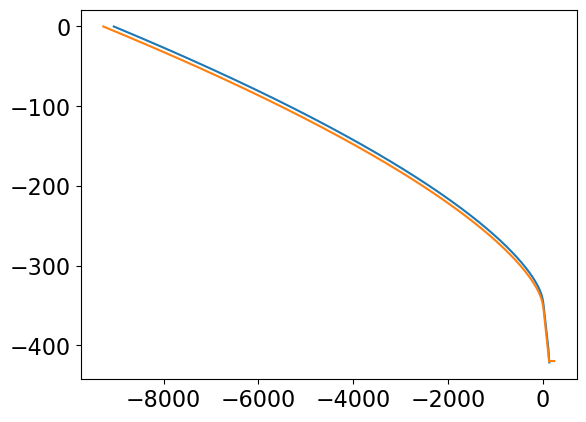

In [10]:
plt.figure()
plt.plot(wf_pn['t'], wf_pn['phase'][2,2])
plt.plot(wf_nr['t'], wf_nr['phase'][2,2])

In [11]:
def PhaseModel(x, dt, dphi, dpsi, m=None, phase_x=None, phase_y=None):
    iphase = IUS(phase_x, phase_y, ext=3)

    return iphase(x+dt) + m*dphi + 2*dpsi

In [12]:
# here we will apply the time, phase and polarisation shifts to the PN waveform
# and leave the NR waveform alone.

In [13]:
ell = 3
m = 2
mode = (ell, m)

In [14]:
model = lmfit.Model(PhaseModel, m=m, phase_x=wf_pn['t'], phase_y=wf_pn['phase'][mode])
params = model.make_params(
    dt=dict(value=0),
    dphi=dict(value=0),
    dpsi=dict(value=0, vary=False))

In [15]:
win1 = -3000
win2 = -1000
mask = np.where( (wf_nr['t'] >= win1) & (wf_nr['t'] <= win2) )

x_fit = wf_nr['t'][mask]
y_fit = wf_nr['phase'][mode][mask]

In [16]:
result = model.fit(y_fit, params, x=x_fit)

In [17]:
result

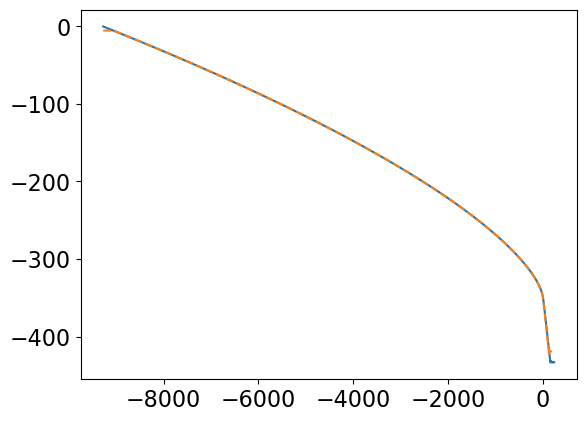

In [18]:
plt.plot(wf_nr['t'], wf_nr['phase'][mode])
plt.plot(wf_nr['t'], model.eval(result.params, x=wf_nr['t']), ls='--')

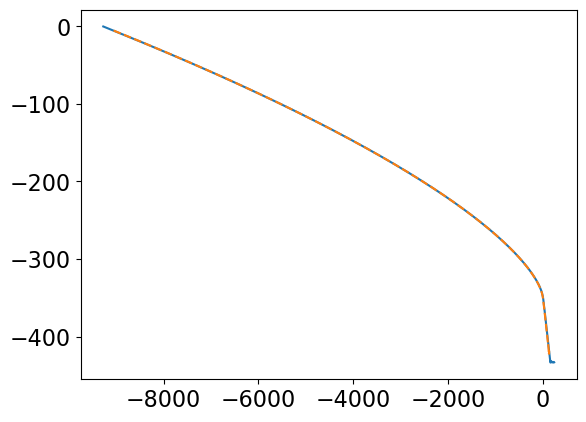

In [19]:
plt.plot(wf_nr['t'], wf_nr['phase'][mode])
plt.plot(wf_pn['t'] - result.params['dt'], wf_pn['phase'][mode]+m*result.params['dphi'], ls='--')

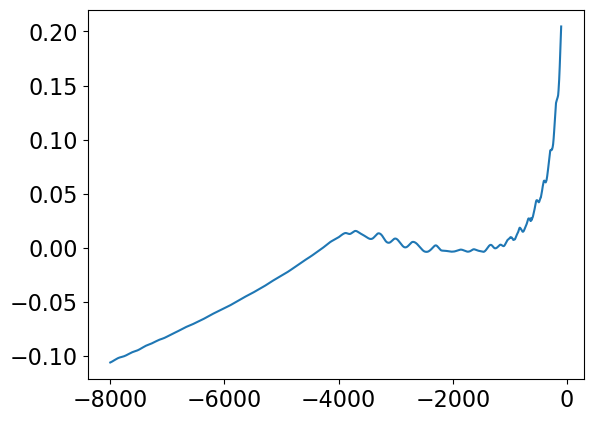

In [20]:
mask = np.where( (wf_nr['t'] > -8000 ) & (wf_nr['t'] < -100) )
plt.plot(wf_nr['t'][mask], wf_nr['phase'][mode][mask]-model.eval(result.params, x=wf_nr['t'][mask]))

(-0.9, 0.0)

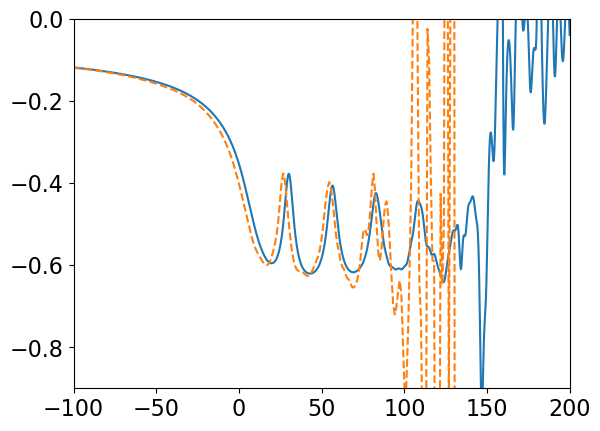

In [21]:
plt.plot(wf_nr['t'], wf_nr['freq'][mode])
plt.plot(wf_pn['t'] - result.params['dt'], wf_pn['freq'][mode], ls='--')
plt.xlim(-100, 200)
plt.ylim(-0.9,0)